In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [56]:
# Завантаження даних
PATH_TO_DATA = '/Users/ivanna/Documents/University/semester_5/PROJECT/new_data/'
orders = pd.read_csv(f'{PATH_TO_DATA}orders_final.csv')  # Ваш файл з замовленнями
order_products = pd.read_csv(f'{PATH_TO_DATA}order_products_prior_final.csv')  # Ваш файл з продуктами в замовленнях
products = pd.read_csv(f'{PATH_TO_DATA}products_final.csv')  # Ваш файл з продуктами

In [57]:
product_count = order_products.groupby("product_id")["order_id"].count()
product_count.rename("count", inplace=True)
product_count_less_100 = product_count[product_count.values < 100]
order_index = order_products[order_products["product_id"].isin(product_count_less_100.index)]["order_id"]
order_products = order_products[~order_products["order_id"].isin(order_index)]

In [58]:
order_products

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
24013548,3421082,16797,3,0
24013549,3421082,43352,4,1
24013550,3421082,32700,5,1
24013551,3421082,12023,6,0


In [59]:
# Об'єднуємо дані про замовлення та продукти
order_products = order_products.merge(products[['product_id', 'product_name']], on='product_id', how='left')
combined_data = order_products.merge(orders[['order_id', 'user_id']], on='order_id', how='left')
combined_data

,order_id,product_id,add_to_cart_order,reordered,product_name,user_id
0,2,33120,1,1,Organic Egg Whites,202279
1,2,28985,2,1,Michigan Organic Kale,202279
2,2,9327,3,0,Garlic Powder,202279
3,2,45918,4,1,Coconut Butter,202279
4,2,30035,5,0,Natural Sweetener,202279
...,...,...,...,...,...,...
20876222,3421082,16797,3,0,Strawberries,175185
20876223,3421082,43352,4,1,Raspberries,175185
20876224,3421082,32700,5,1,Original Whipped Cream,175185
20876225,3421082,12023,6,0,Toasted Coconut Chips Original Recipe,175185


In [60]:
# Підрахунок частоти покупок продуктів разом
co_occurrence = combined_data.groupby(['product_id', 'product_name'])['order_id'].count().reset_index(name='frequency')
co_occurrence_matrix = co_occurrence.pivot(index='product_id', columns='product_name', values='frequency').fillna(0)

In [61]:
# Використання LLM для семантичного токенізування продуктів
model = SentenceTransformer('all-MiniLM-L6-v2')
product_names = co_occurrence['product_name'].unique()
product_embeddings = model.encode(product_names)

In [62]:
# Створення DataFrame для векторів продуктів
product_vectors = pd.DataFrame(product_embeddings, index=product_names)

# Об'єднання частот та семантичних векторів
co_occurrence_matrix = co_occurrence_matrix.values
combined_matrix = np.concatenate((product_vectors.values, co_occurrence_matrix), axis=1)

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
combined_matrix_scaled = scaler.fit_transform(combined_matrix)

In [64]:
# Кластеризація методом K-Means
kmeans = KMeans(n_clusters=100, random_state=42)  # n_clusters - кількість кластерів
kmeans.fit(combined_matrix_scaled)

KMeans(n_clusters=100, random_state=42)

In [65]:
# Отримання кластерів
kmeans_clusters = kmeans.labels_

In [66]:
# Додавання кластерів до векторів продуктів
product_vectors['cluster'] = kmeans_clusters

In [67]:
# Візуалізація результатів кластеризації за допомогою PCA
pca = PCA(n_components=2)
reduced_data_kmeans = pca.fit_transform(combined_matrix_scaled)

In [68]:
# Get unique clusters
unique_clusters = np.unique(kmeans_clusters)

# Number of clusters (excluding noise)
n_clusters = len(unique_clusters[unique_clusters != -1])

# Total number of clusters (including noise)
n_clusters_with_noise = len(unique_clusters)

print(f"Number of clusters (excluding noise): {n_clusters}")
print(f"Number of clusters (including noise): {n_clusters_with_noise}")


Number of clusters (excluding noise): 100
Number of clusters (including noise): 100


In [69]:
# Додавання кластерів до даних продуктів
product_vectors['cluster'] = kmeans_clusters

In [70]:
product_vectors["cluster"].unique()

array([92, 26, 79, 37, 98, 52, 62, 21, 41, 39, 19, 88, 83, 58, 46, 40, 28,
       34, 38, 17,  9,  2, 69, 31, 80, 23, 25, 71, 72,  0, 86, 11, 30, 51,
       74,  8, 96, 82, 67,  7, 73, 18, 94, 13, 84, 20, 61, 89, 65, 76, 48,
       68, 54, 87, 91, 42, 33, 22, 15, 66, 56,  4,  5, 93, 35, 36, 57, 77,
       60, 12, 16, 29, 50, 99, 70, 10, 47, 64, 75, 59, 90, 45,  6, 81, 32,
        1,  3, 78, 53, 85, 97, 95, 24, 43, 49, 14, 44, 27, 63, 55],
      dtype=int32)

In [71]:
# Візуалізація результатів кластеризації за допомогою PCA
pca = PCA(n_components=2)
reduced_data_kmeans = pca.fit_transform(combined_matrix_scaled)

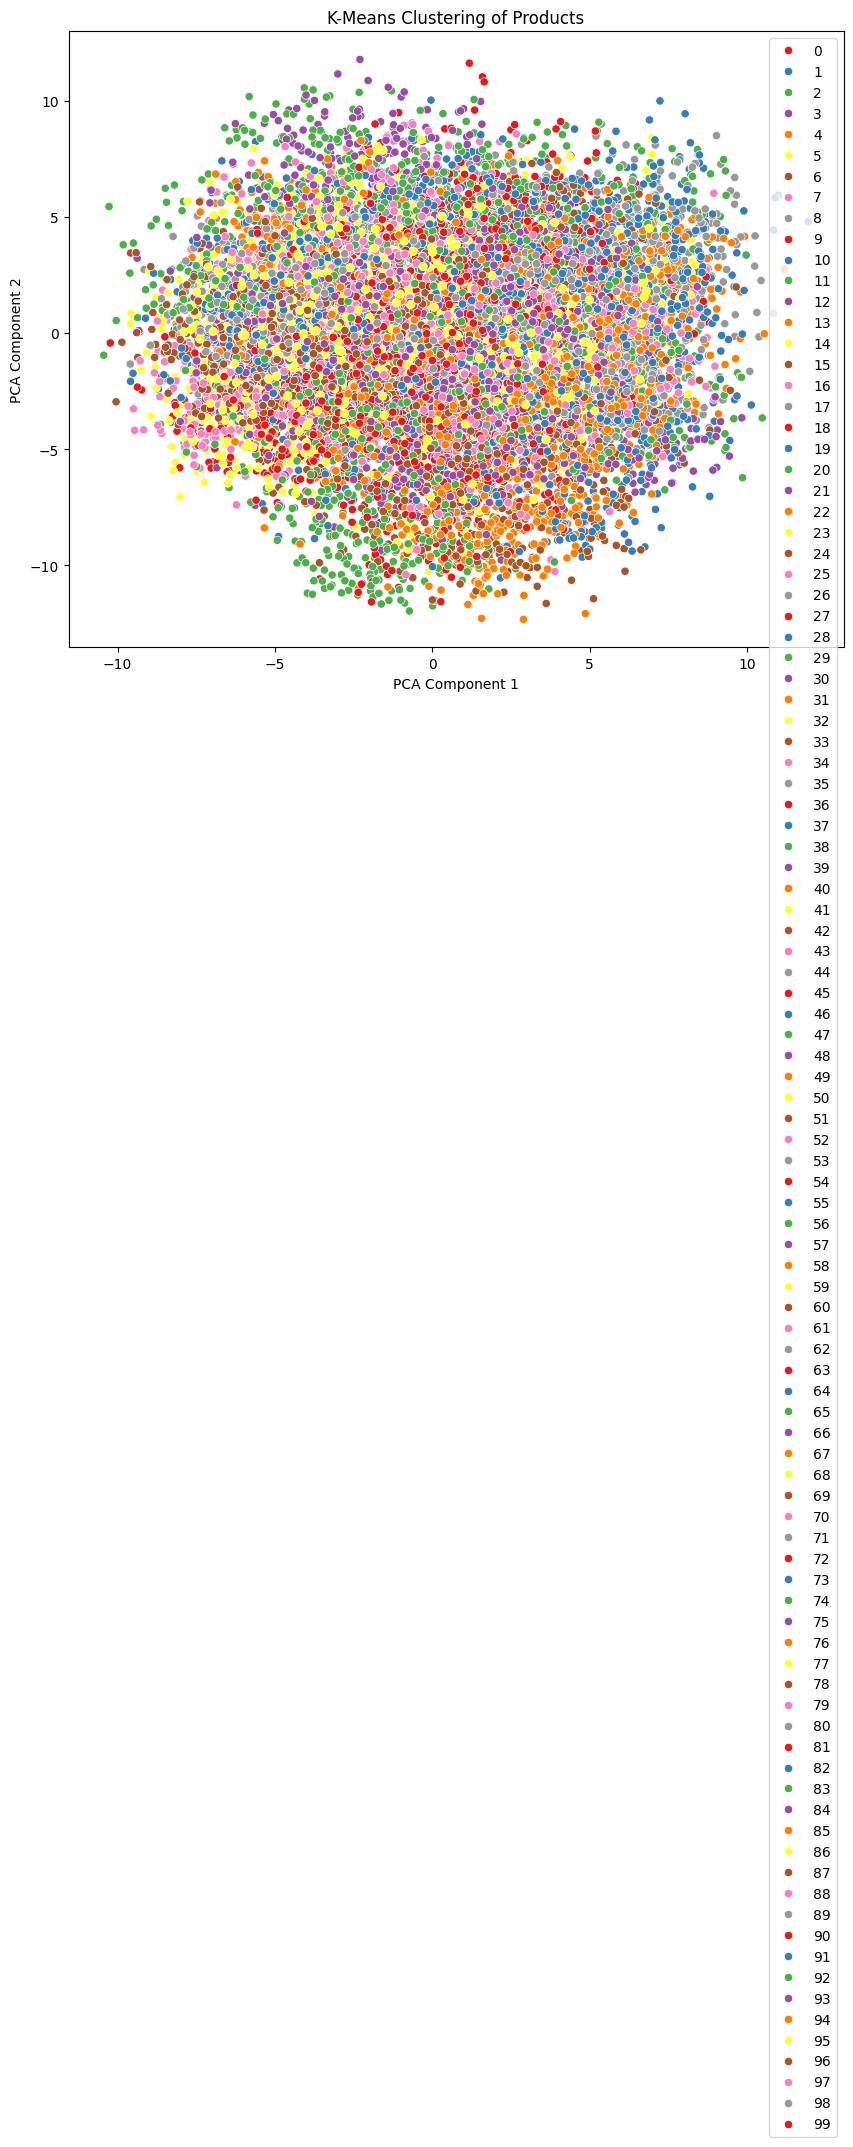

In [72]:
# Відображення результатів кластеризації K-Means
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data_kmeans[:, 0], y=reduced_data_kmeans[:, 1], hue=kmeans_clusters, palette='Set1')
plt.title('K-Means Clustering of Products')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()